# Fraud / Anomaly Detection — Credit Card Transactions

**Goal:** Build an end-to-end baseline for fraud detection under severe class imbalance, focusing on **PR-AUC** and **precision–recall trade-offs** via threshold tuning.

**Dataset:** Kaggle Credit Card Fraud Detection (`creditcard.csv`)  
**Note:** Data is stored locally under `data/` and excluded from version control.

---

## Outline
1. Setup & data overview  
2. Exploratory data analysis (EDA)  
3. Key observations (EDA)  
4. Baseline modeling: Logistic Regression (leakage-free pipeline)  
5. Threshold tuning (operating point selection)  
6. Observations from baseline modeling  


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data (place creditcard.csv under ../data/)
df = pd.read_csv("../data/creditcard.csv")

print("Shape:", df.shape)


Shape: (284807, 31)


In [2]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('Missing values:', int(df.isna().sum().sum()))

Missing values: 0


## Exploratory Data Analysis (EDA)

### Class Imbalance

In [4]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [5]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

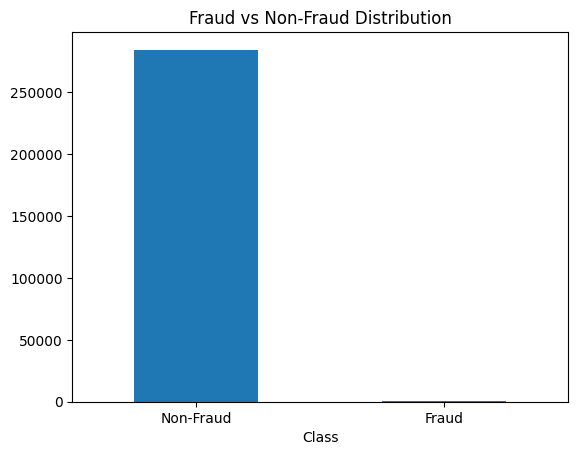

In [6]:
import matplotlib.pyplot as plt

df['Class'].value_counts().plot(kind='bar')
plt.title("Fraud vs Non-Fraud Distribution")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.show()

### Transaction Time Distribution

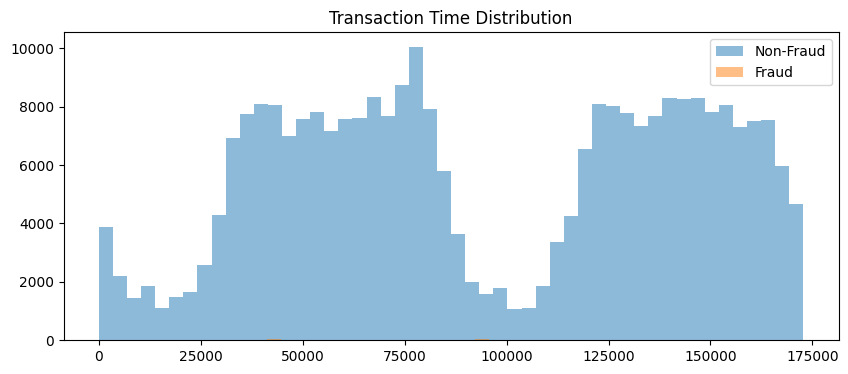

In [7]:
plt.figure(figsize=(10,4))
plt.hist(df[df['Class']==0]['Time'], bins=50, alpha=0.5, label='Non-Fraud')
plt.hist(df[df['Class']==1]['Time'], bins=50, alpha=0.5, label='Fraud')
plt.legend()
plt.title("Transaction Time Distribution")
plt.show()

### Transaction Amount Distribution (Log Scale)

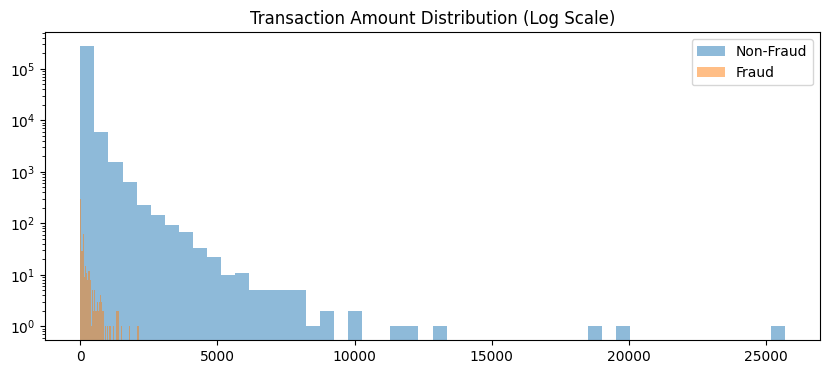

In [8]:
plt.figure(figsize=(10,4))

plt.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.5, label='Non-Fraud')
plt.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.5, label='Fraud')

plt.yscale('log')   # 👈 关键
plt.legend()
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()

## Key Observations (EDA)

1. The dataset is highly imbalanced with only 0.17% fraud cases.
2. Fraud transactions appear to concentrate in lower transaction amounts.
3. The transaction amount distribution is highly right-skewed with extreme outliers in non-fraud transactions.

## Baseline Model — Logistic Regression (Pipeline)

Why a pipeline?
- Logistic Regression is sensitive to feature scaling.
- Fitting the scaler on the full dataset can leak information from test to train.
- A `Pipeline` ensures scaling is fit **only on the training split**.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score

X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

lr.fit(X_train, y_train)

# Probabilities for threshold tuning and PR-AUC
y_prob = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)  # default threshold = 0.5

print("Logistic Regression PR-AUC:", average_precision_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=3))


Logistic Regression PR-AUC: 0.7189705771419241
              precision    recall  f1-score   support

           0      1.000     0.976     0.988     56864
           1      0.061     0.918     0.114        98

    accuracy                          0.976     56962
   macro avg      0.530     0.947     0.551     56962
weighted avg      0.998     0.976     0.986     56962



/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/s

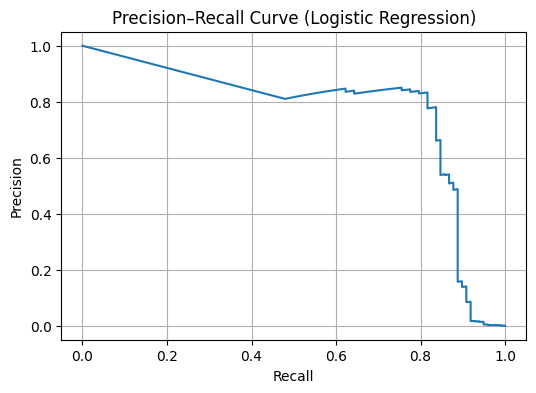

In [10]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Logistic Regression)")
plt.grid(True)
plt.show()


## Threshold Tuning (Operating Point Selection)

We tune the decision threshold to trade off **precision** vs **recall** depending on operational constraints (e.g., reviewer capacity, user impact).

In [11]:
from sklearn.metrics import confusion_matrix

def show_metrics(threshold):
    y_pred_t = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    print(f"\nThreshold={threshold}")
    print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    print(f"Precision={precision:.4f}, Recall={recall:.4f}")

for t in [0.9, 0.7, 0.5, 0.3, 0.2, 0.1]:
    show_metrics(t)



Threshold=0.9
TP=87, FP=265, FN=11, TN=56599
Precision=0.2472, Recall=0.8878

Threshold=0.7
TP=89, FP=645, FN=9, TN=56219
Precision=0.1213, Recall=0.9082

Threshold=0.5
TP=90, FP=1386, FN=8, TN=55478
Precision=0.0610, Recall=0.9184

Threshold=0.3
TP=90, FP=3201, FN=8, TN=53663
Precision=0.0273, Recall=0.9184

Threshold=0.2
TP=92, FP=5515, FN=6, TN=51349
Precision=0.0164, Recall=0.9388

Threshold=0.1
TP=93, FP=11315, FN=5, TN=45549
Precision=0.0082, Recall=0.9490


## Observations from Baseline Modeling

1. The dataset is extremely imbalanced (0.17% fraud cases), making accuracy an unreliable metric.

2. Logistic Regression without class weighting achieved high accuracy but moderate recall (~0.64), missing a significant portion of fraud cases.

3. Applying class_weight='balanced' significantly increased recall (~0.92), but drastically reduced precision, introducing a large number of false positives.

4. Threshold tuning revealed a clear precision-recall trade-off:
   - Lower thresholds increased recall but produced excessive false positives.
   - Higher thresholds (e.g., 0.9) provided a more practical operating point with manageable false positives while maintaining high recall.

5. The Precision-Recall curve indicates that the model has reasonable ranking capability (PR-AUC ≈ 0.72), but performance degrades rapidly in high-recall regions.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]

In [13]:
from sklearn.metrics import average_precision_score

rf_ap = average_precision_score(y_test, rf_prob)
print("Random Forest PR-AUC:", rf_ap)

Random Forest PR-AUC: 0.8555650790558139


In [14]:
print("Logistic Regression PR-AUC:", average_precision_score(y_test, y_prob))

Logistic Regression PR-AUC: 0.7189705771419241


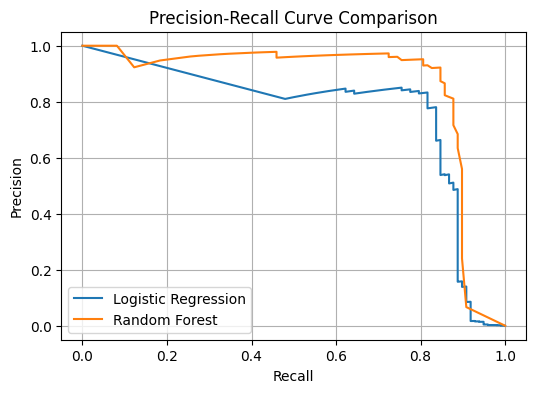

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

lr_prec, lr_rec, _ = precision_recall_curve(y_test, y_prob)
rf_prec, rf_rec, _ = precision_recall_curve(y_test, rf_prob)

plt.figure(figsize=(6,4))
plt.plot(lr_rec, lr_prec, label="Logistic Regression")
plt.plot(rf_rec, rf_prec, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Model Comparison

Random Forest significantly outperformed Logistic Regression in PR-AUC 
(0.85 vs 0.72), indicating stronger ranking capability under severe class imbalance.

The Precision-Recall curve shows that the tree-based model maintains 
higher precision across most recall regions, especially in high-recall settings.

This suggests that fraud detection in this dataset involves nonlinear feature interactions, 
which are better captured by ensemble methods.

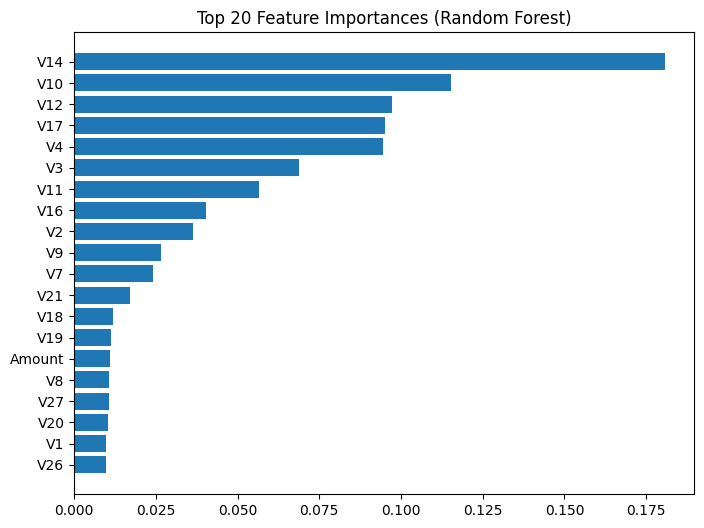

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top20 = feat_df.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

## Final Conclusion

- Fraud detection is highly imbalanced and requires PR-AUC evaluation.
- Logistic Regression provides a reasonable baseline but struggles with nonlinear patterns.
- Random Forest significantly improves ranking performance.
- Threshold tuning is essential for balancing false positives and false negatives in production settings.